In [1]:
import argparse
import json
import os
from animus.torch.engine import CPUEngine, DDPEngine, DPEngine, GPUEngine, XLAEngine
from neurone.utils.general import load_yaml
import torch
import datetime 
from datetime import datetime 
import numpy as np

# Runners
from neurone.runners.detection import BaseDetectionRunner, HeatmapDetectionRunner
from neurone.runners.segmentation import BaseSegmentationRunner
#from neurone.runners.extended import HeatmapExtendedDetectionRunner
from neurone.runners.gridsearch import GridSearchRunner

E2E = {
    "cpu": CPUEngine,
    "gpu": GPUEngine,
    "dp": DPEngine,
    "ddp": DDPEngine,
    "xla": XLAEngine,
}

#args.engine = "cpu"
#args.tracker = "tensorboard"

print('Get current working directory : ', os.getcwd())
config_path = "./configs/config.json"
!cat ./configs/config.json
with open(config_path, "r") as config_file:
        config = json.load(config_file)
        
        
config["data"]["split_info"] = "/home/data-histology/endonuke_data/trainval/split_info.yml"
config["train"]["experiment_name"] = config["train"]["save_dir"] + " " + config["train"]["experiment_name"]  + " " + str(datetime.now())
#whether to overwrite the model or not
#config["train"]["verbose"] = True
#config["train"]["overwrite"] = True
config["train"]["deterministic"] = False
config["train"]["seed"] = 42
config["train"]["checkpoints_dir"] = "checkpoints"
config["train"]["logging_dir"] = "logs"
config['train']['tracker'] = "tensorboard"
config["train"]["engine"] = "cpu"
if config["train"]["deterministic"]:
    torch.use_deterministic_algorithms(config["train"]["deterministic"])
logging_dir = os.path.join(config["train"]["save_dir"], config["train"]["experiment_name"])
    
runner = globals()[config["model"]["runner"]](engine=E2E["cpu"](
    log_with="tensorboard", logging_dir=logging_dir), config=config)
        

Get current working directory :  /home/alexmak123/neurone
{
    "model": {
        "runner": "BaseDetectionRunner",
        "model_name": "HeatmapDetector",
        "model_kwargs": {
            "backbone": "UnetPlusPlus",
            "encoder_name": "resnet50",
            "encoder_depth": 5,
            "encoder_weights": "imagenet",
            "in_channels": 3,
            "classes": 1,
            "activation": null,
            "min_peak_value": 0.245,
            "pooling_scale": 7,
            "out_image_shape": [
                512,
                512
            ],
            "supression_range": 3.099
        },
        "weigths_path": "/home/alexmak123/neurone/experiments/1_class_model_for_detection/model.pth",
        "class_separator": null,
        "class_labels_map": {
            "0": 0,
            "1": 0,
            "2": 0
        },
        "input_shape": [
            512,
            512
        ],
        "extractor_params": {
            "pooling_scale": 11,


In [2]:
# Specify Model
runner._setup_model()
runner.model.eval()

HeatmapDetector(
  (heatmap_model): UnetPlusPlus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

/home/alexmak123/result_tiles_for_validation_without_context


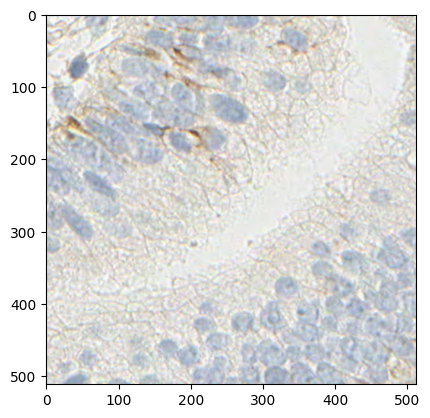

In [3]:
#Download our tile
%cd ../result_tiles_for_validation_without_context/

import cv2
from PIL import Image
import matplotlib.pyplot as plt

filename = "21-177-1CD138_1.png"
myTile = np.array(Image.open(filename).convert('RGB'))

plt.imshow(myTile)



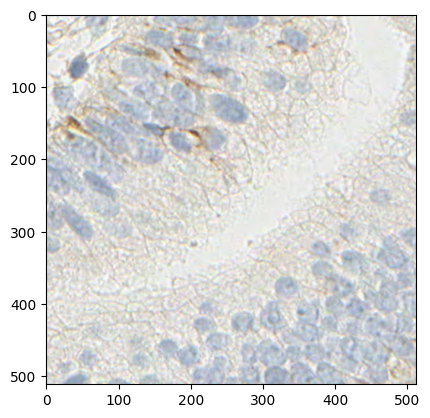

In [4]:
#Right now we will cut our pic on 4 parts and apply 1 class detection model to one of them 
import albumentations as A
alb_transforms = A.Compose([A.augmentations.Resize(512, 512)])

M = myTile.shape[0]//1
N = myTile.shape[1]//1
tiles = [myTile[x:x+M,y:y+N] for x in range(0,myTile.shape[0],M) for y in range(0,myTile.shape[1],N)]

i = 0
for tile in tiles :
    tile = alb_transforms(image=tile)["image"]
    tiles[i] = tile
    i += 1
    
plt.imshow(tiles[0])

In [5]:
#apply our model to 1/4 part of the original pic
import sys


#our data to tensor
image_torch = torch.tensor(tiles)
print (image_torch.shape)

#image_torch = torch.unsqueeze(image_torch, 0)
image_torch = image_torch.permute(0, 3, 1, 2) 
image_torch = image_torch.float()

#here should be meanstd values, counted for this picture, but with counted meanstd it doesn't classify properly on stroma and epithelium. That's why we use standard meanstd values

#!!!NOTE: ASK ABOUT THIS!!!
#config["data"]["norm_mean"][0], config["data"]["norm_mean"][1], config["data"]["norm_mean"][2] = (170, 154, 144)
#config["data"]["norm_std"][0], config["data"]["norm_std"][1], config["data"]["norm_std"][2] = (63, 69, 71)
image_torch -= torch.tensor([config["data"]["norm_mean"][0], config["data"]["norm_mean"][1], config["data"]["norm_mean"][2]]).reshape(-1, 1, 1)
image_torch /= torch.tensor([config["data"]["norm_std"][0], config["data"]["norm_std"][1], config["data"]["norm_std"][2]]).reshape(-1, 1, 1)
    

#np.set_printoptions(threshold=sys.maxsize)
print ("Keypoints of all tiles : \n")
keypoints = runner.model(image_torch)["keypoints"]
print (keypoints, "\n")
print ("Confidences of all tiles : \n")
confidences = runner.model(image_torch)["confidences"]
print (confidences, "\n")

x_coords = keypoints.x_coords()
y_coords = keypoints.y_coords()
classes = keypoints.classes()

/tmp/ipykernel_416889/3726488449.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  image_torch = torch.tensor(tiles)


torch.Size([1, 512, 512, 3])
Keypoints of all tiles : 

[[  0. 170. 459.   0.]
 [  0.  44.  73.   0.]
 [  0. 318.  92.   0.]
 [  0. 218. 429.   0.]
 [  0. 185. 178.   0.]
 [  0. 142.  53.   0.]
 [  0. 381. 323.   0.]
 [  0. 150. 159.   0.]
 [  0. 381. 351.   0.]
 [  0. 462. 251.   0.]
 [  0. 334. 378.   0.]
 [  0. 196. 473.   0.]
 [  0. 272. 427.   0.]
 [  0. 200.  96.   0.]
 [  0. 236. 453.   0.]
 [  0. 189. 111.   0.]
 [  0.  41. 506.   0.]
 [  0. 318. 499.   0.]
 [  0. 124.  75.   0.]
 [  0. 432. 405.   0.]
 [  0. 346.  35.   0.]
 [  0. 166.  83.   0.]
 [  0. 236.  79.   0.]
 [  0.  76. 236.   0.]
 [  0. 313. 420.   0.]
 [  0. 132. 479.   0.]
 [  0. 144. 196.   0.]
 [  0. 494. 367.   0.]
 [  0.  24. 115.   0.]
 [  0.  58. 475.   0.]
 [  0. 258. 138.   0.]
 [  0. 418. 301.   0.]
 [  0. 155.  32.   0.]
 [  0. 504. 306.   0.]
 [  0. 476. 341.   0.]
 [  0. 234. 173.   0.]
 [  0. 142. 506.   0.]
 [  0. 399. 401.   0.]
 [  0. 354. 491.   0.]
 [  0. 503. 144.   0.]
 [  0. 277.   6.   0.]
 

In [6]:
j = 0
selected_columns_array = []

for index_tile in range(len(tiles)):
    selected_columns = []
    while (j < keypoints.shape[0] and keypoints[j][0] == index_tile):
        selected_columns.append([keypoints[j][1], keypoints[j][2], keypoints[j][3]])
        j += 1
    selected_columns_array.append(np.array(selected_columns))
    
print (np.array(selected_columns_array, dtype=object))

[[[170.0 459.0 0.0]
  [44.0 73.0 0.0]
  [318.0 92.0 0.0]
  [218.0 429.0 0.0]
  [185.0 178.0 0.0]
  [142.0 53.0 0.0]
  [381.0 323.0 0.0]
  [150.0 159.0 0.0]
  [381.0 351.0 0.0]
  [462.0 251.0 0.0]
  [334.0 378.0 0.0]
  [196.0 473.0 0.0]
  [272.0 427.0 0.0]
  [200.0 96.0 0.0]
  [236.0 453.0 0.0]
  [189.0 111.0 0.0]
  [41.0 506.0 0.0]
  [318.0 499.0 0.0]
  [124.0 75.0 0.0]
  [432.0 405.0 0.0]
  [346.0 35.0 0.0]
  [166.0 83.0 0.0]
  [236.0 79.0 0.0]
  [76.0 236.0 0.0]
  [313.0 420.0 0.0]
  [132.0 479.0 0.0]
  [144.0 196.0 0.0]
  [494.0 367.0 0.0]
  [24.0 115.0 0.0]
  [58.0 475.0 0.0]
  [258.0 138.0 0.0]
  [418.0 301.0 0.0]
  [155.0 32.0 0.0]
  [504.0 306.0 0.0]
  [476.0 341.0 0.0]
  [234.0 173.0 0.0]
  [142.0 506.0 0.0]
  [399.0 401.0 0.0]
  [354.0 491.0 0.0]
  [503.0 144.0 0.0]
  [277.0 6.0 0.0]
  [48.0 295.0 0.0]
  [37.0 149.0 0.0]
  [126.0 134.0 0.0]
  [415.0 375.0 0.0]
  [422.0 337.0 0.0]
  [314.0 466.0 0.0]
  [470.0 399.0 0.0]
  [342.0 465.0 0.0]
  [392.0 426.0 0.0]
  [282.0 470.0 0.0

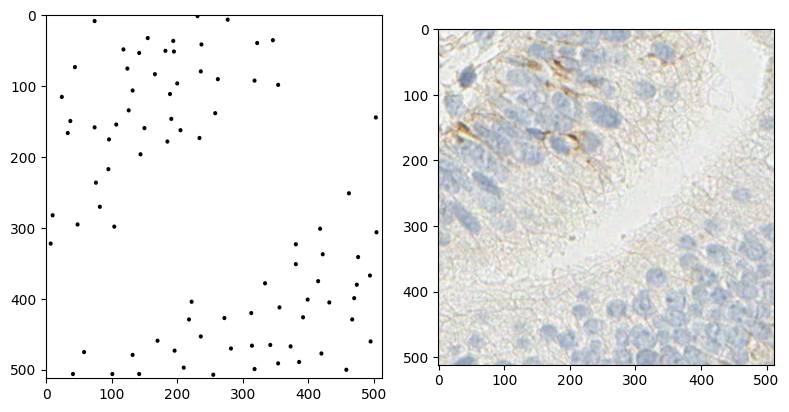

In [7]:
#make pictures
#Set the figure size
plt.rcParams["figure.figsize"] = [8, 8]
plt.rcParams["figure.autolayout"] = True

for index_tile in range(len(tiles)):
    plt.subplot(2, 2, 1)
    #with circles
    ax = plt.gca()
    ax.cla()
    ax.set_xlim((0, 512))
    ax.set_ylim((0, 512))
    ax.invert_yaxis()
    circles_type={"radius": 2, "alpha": 1.0,  "linewidth": 1, 'ec': (0,0,0)}
    colormap = np.array(['k', 'b'])
    for dot_center in selected_columns_array[index_tile]:
        patch = plt.Circle((dot_center[0], dot_center[1]), color=colormap[dot_center[2].astype(int)], **circles_type)
        ax.add_patch(patch)


    plt.subplot(2, 2, 2)
    plt.imshow(tiles[index_tile])
    plt.show()

In [9]:
offset_fraction = 0.25
koef_translation = 512 * offset_fraction
new_x = [None]*(len(x_coords))
new_y = [None]*(len(y_coords))
string_for_stroma = ""
string_for_epitelium = ""
for i in range(len(x_coords)):
    new_x[i] = x_coords[i] + koef_translation
    new_y[i] = y_coords[i] + koef_translation
    
for i in range(len(x_coords)):
    if (classes[i] == 0):
        string_for_stroma += str(new_x[i]) + "," + str(new_y[i]) + ";"
    if (classes[i] == 1):
        string_for_epitelium += str(new_x[i]) + "," + str(new_y[i]) + ";"
        
print ("stroma :")
print (string_for_stroma)
print ("epitelium :")
print (string_for_epitelium)

stroma :
298.0,587.0;172.0,201.0;446.0,220.0;346.0,557.0;313.0,306.0;270.0,181.0;509.0,451.0;278.0,287.0;509.0,479.0;590.0,379.0;462.0,506.0;324.0,601.0;400.0,555.0;328.0,224.0;364.0,581.0;317.0,239.0;169.0,634.0;446.0,627.0;252.0,203.0;560.0,533.0;474.0,163.0;294.0,211.0;364.0,207.0;204.0,364.0;441.0,548.0;260.0,607.0;272.0,324.0;622.0,495.0;152.0,243.0;186.0,603.0;386.0,266.0;546.0,429.0;283.0,160.0;632.0,434.0;604.0,469.0;362.0,301.0;270.0,634.0;527.0,529.0;482.0,619.0;631.0,272.0;405.0,134.0;176.0,423.0;165.0,277.0;254.0,262.0;543.0,503.0;550.0,465.0;442.0,594.0;598.0,527.0;470.0,593.0;520.0,554.0;410.0,598.0;484.0,540.0;501.0,595.0;135.0,450.0;310.0,178.0;365.0,169.0;319.0,274.0;323.0,179.0;229.0,634.0;232.0,426.0;161.0,294.0;322.0,164.0;623.0,588.0;586.0,628.0;333.0,290.0;595.0,557.0;482.0,226.0;514.0,617.0;260.0,234.0;338.0,625.0;202.0,136.0;390.0,218.0;224.0,303.0;383.0,635.0;350.0,532.0;202.0,286.0;359.0,129.0;450.0,167.0;138.0,410.0;548.0,605.0;602.0,508.0;210.0,398.0;223.0,3